# ✅ 1. Define the libraries and upload the dataset

In [1]:
# Step 1: Create a new environment
!python -m venv cleanenv

# Step 2: Activate it
# On Windows:
!cleanenv\Scripts\activate
# On Mac/Linux:
#source cleanenv/bin/activate

# Step 3: Install only what you need
!pip install numpy==1.26.4 scipy==1.13.0 scikit-learn==1.5.0 imbalanced-learn==0.13.0 tensorflow==2.18.0

Error: Command '['/kaggle/working/cleanenv/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: line 1: cleanenvScriptsactivate: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 99.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy

In [2]:
# GOOD (pick one)
import torch                         # PyTorch only
# OR
import tensorflow as tf              # TensorFlow only
# OR
import jax                           # JAX only

2025-10-29 11:19:49.267452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761736789.475063      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761736789.535071      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Import TF first so cuDNN is registered once
import tensorflow as tf
import torch

In [4]:
import numpy, scipy, sklearn, imblearn, tensorflow as tf

print("numpy:", numpy.__version__)
print("scipy:", scipy.__version__)
print("scikit-learn:", sklearn.__version__)
print("imbalanced-learn:", imblearn.__version__)
print("tensorflow:", tf.__version__)

numpy: 1.26.4
scipy: 1.13.0
scikit-learn: 1.5.0
imbalanced-learn: 0.13.0
tensorflow: 2.18.0


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.utils import resample
from collections import Counter

This script creates **hourly-level dynamic features** for each patient during **Ramadan** using continuous glucose monitoring (CGM) data and lifestyle metrics (activity, sleep, physiology) from wearable devices.
It’s part of a preprocessing pipeline for modeling glucose behavior and hypoglycemia risk.

Here’s a complete explanation 👇

---

## 🧩 **Overall Goal**

To transform raw timestamped CGM and wearable data into **hourly summarized features** that represent glucose dynamics, lifestyle behavior, and physiological activity during Ramadan — ready for statistical or machine-learning analysis.

---

## 🧭 **1️⃣ Load and Parse Data**

* Loads the file:

  ```
  intraday_with_visits.csv
  ```

  which includes per-minute or per-sample CGM and Huawei sensor data.
* Converts all timestamps (`start`, `date`) to datetime format.
* Extracts:

  * `hour` → the nearest hour (e.g., 14:00, 15:00).
  * `hour_of_day` → the hour index (0–23).

👉 *Purpose:* Prepare a unified hourly timeline for every patient.

---

## 📆 **2️⃣ Filter for Ramadan Period**

* Keeps only data between **March 22 – April 19, 2023**.
* Ensures the dataset includes `cgm` readings (continuous glucose values).
* Adds a **binary flag `hypo`** = `True` when CGM ≤ 70 mg/dL (hypoglycemia reading).

👉 *Purpose:* Focus analysis strictly on the fasting month, removing other phases.

---

## ⏱ **3️⃣ Validate Hourly Windows**

* Keeps only hours with **≥4 CGM readings** to ensure data quality.
* This removes incomplete or sparse hours.

👉 *Purpose:* Guarantee each hourly feature represents stable glucose behavior.

---

## 📊 **4️⃣ Compute Hourly CGM Statistics**

For each patient and hour:

* `cgm_min` → minimum glucose value
* `cgm_max` → maximum glucose value
* `cgm_mean` → mean glucose level
* `cgm_std` → standard deviation (glucose variability)

Also adds:

* `hypo_label` → `1` if any CGM reading in that hour was ≤70 mg/dL.

👉 *Purpose:* Capture both variability and hypoglycemia presence within each hour.

---

## 🧮 **5️⃣ Composite Glucose Features**

Creates two derived indicators:

* `cgm_mean_plus_std`  → average + variability
* `cgm_mean_minus_std` → average – variability

👉 *Purpose:* Encode range boundaries for dynamic glucose variation.

---

## 🧠 **6️⃣ PCA on CGM Variables**

* Runs **Principal Component Analysis (PCA)** on `[cgm_min, cgm_max, cgm_mean, cgm_std]`.
* Extracts **3 principal components** (`pca_cgm1`, `pca_cgm2`, `pca_cgm3`).
* Reports explained variance (usually >95%).

👉 *Purpose:* Compress CGM dynamics into orthogonal, interpretable axes — summarizing glucose pattern, amplitude, and variability.

---

## 🏃‍♀️ **7️⃣ PCA on Lifestyle / Activity / Sleep Features**

* Selects available columns:

  ```
  steps, distance, calories, heart_rate, spo2, deep, light, rem, nap, awake
  ```
* Averages these per hour per patient.
* Runs PCA → extracts **3 lifestyle components**:

  * `pc1_activity_energy` → overall activity/energy output
  * `pc2_physiology` → physiological or heart-rate–related factors
  * `pc3_sleep_rest` → rest and sleep quality indices
* Reports explained variance ratio.

👉 *Purpose:* Reduce multiple wearable signals into interpretable latent factors.

---

## 📑 **8️⃣ Finalize and Sort**

* Orders the dataset by patient and hour.
* Keeps only relevant feature columns:

  ```
  cgm_min, cgm_max, cgm_mean, cgm_std,
  cgm_mean_plus_std, cgm_mean_minus_std,
  pca_cgm1–3, pc1_activity_energy, pc2_physiology, pc3_sleep_rest, hypo_label
  ```
* Prints a preview of the final dataset.

---

## 💾 **9️⃣ Save Hourly Feature File**

Exports the final hourly-level dataset to:

```
/kaggle/working/dynamic_hourly_features_ramadan.csv
```

Each row now represents **one patient-hour** with fully engineered glucose and lifestyle features.

---

## ✅ **Summary in One Line**

> This code aggregates intraday CGM and wearable sensor data into **hourly-level Ramadan features**, computing glucose statistics, detecting hypoglycemia, and summarizing glucose and lifestyle variability using **PCA-derived composite components** — producing a clean, feature-rich dataset for modeling hourly glucose dynamics during fasting.


In [6]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA

# =========================
# CONFIG
# =========================
CSV_PATH = "/kaggle/input/hmcdataset/intraday_with_visits.csv"  # ✅ update path if needed
OUT_HOURLY_CSV = "/kaggle/working/dynamic_hourly_features_ramadan.csv"

RAMADAN_START = pd.to_datetime("2023-03-22")
RAMADAN_END   = pd.to_datetime("2023-04-19")

# =========================
# STEP 0: Load & prepare data
# =========================
df = pd.read_csv(CSV_PATH)

# Parse timestamps
df["start"] = pd.to_datetime(df["start"], errors="coerce")
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["hour"] = df["start"].dt.floor("h")
df["hour_of_day"] = df["start"].dt.hour

# Numeric conversion
for col in df.columns:
    if col not in ["patientID", "huaweiID", "visit_assigned", "period_main", "start", "date", "hour", "hour_of_day"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# =========================
# STEP 0.1: Ramadan filter
# =========================
df = df[(df["date"] >= RAMADAN_START) & (df["date"] <= RAMADAN_END)].copy()

# Ensure CGM exists
if "cgm" not in df.columns:
    raise ValueError("❌ Dataset must include 'cgm' column.")
df_cgm = df.dropna(subset=["cgm"]).copy()

# Hypo reading flag (<= 70 mg/dL)
df_cgm["hypo"] = df_cgm["cgm"] <= 70

# =========================
# STEP 1: Filter valid hours (≥4 CGM readings)
# =========================
valid_hours = (
    df_cgm.groupby(["patientID", "hour"])
    .filter(lambda g: g["cgm"].notna().sum() >= 4)
)

# =========================
# STEP 2: Compute hourly CGM statistics
# =========================
hourly_features = (
    valid_hours
    .groupby(["patientID", "hour_of_day", "hour"], as_index=False)
    .agg(
        cgm_min=("cgm", "min"),
        cgm_max=("cgm", "max"),
        cgm_mean=("cgm", "mean"),
        cgm_std=("cgm", "std")
    )
)

# Hypoglycemia label per hour
hypo_per_hour = (
    valid_hours.groupby(["patientID", "hour"])["cgm"]
    .apply(lambda x: (x < 70).any())
    .reset_index(name="hypo_label")
)
hourly_features = hourly_features.merge(hypo_per_hour, on=["patientID", "hour"], how="left")

# =========================
# STEP 3: Composite CGM features
# =========================
hourly_features["cgm_mean_plus_std"] = hourly_features["cgm_mean"] + hourly_features["cgm_std"]
hourly_features["cgm_mean_minus_std"] = hourly_features["cgm_mean"] - hourly_features["cgm_std"]

# =========================
# STEP 4: PCA on CGM stats → 3 components
# =========================
pca_input_cgm = hourly_features[["cgm_min", "cgm_max", "cgm_mean", "cgm_std"]].fillna(0)
pca_cgm = PCA(n_components=3, random_state=42)
cgm_components = pca_cgm.fit_transform(pca_input_cgm)

hourly_features["pca_cgm1"] = cgm_components[:, 0]
hourly_features["pca_cgm2"] = cgm_components[:, 1]
hourly_features["pca_cgm3"] = cgm_components[:, 2]

print("CGM PCA explained variance:", pca_cgm.explained_variance_ratio_.round(3))

# =========================
# STEP 5: PCA on lifestyle/activity/sleep features
# =========================
lifestyle_cols = ["steps", "distance", "calories", "heart_rate", "spo2",
                  "deep", "light", "rem", "nap", "awake"]
lifestyle_cols = [c for c in lifestyle_cols if c in df_cgm.columns]

if lifestyle_cols:
    lifestyle_hourly = (
        df_cgm.groupby(["patientID", "hour"], as_index=False)[lifestyle_cols]
        .mean()
        .fillna(0)
    )

    # Merge lifestyle into hourly_features
    hourly_features = hourly_features.merge(
        lifestyle_hourly, on=["patientID", "hour"], how="left"
    ).fillna(0)

    # Run PCA
    pca_life = PCA(n_components=3, random_state=42)
    life_components = pca_life.fit_transform(hourly_features[lifestyle_cols])

    hourly_features["pc1_activity_energy"] = life_components[:, 0]
    hourly_features["pc2_physiology"] = life_components[:, 1]
    hourly_features["pc3_sleep_rest"] = life_components[:, 2]

    print("Lifestyle PCA explained variance:", pca_life.explained_variance_ratio_.round(3))

# =========================
# STEP 6: Finalize dataset
# =========================
hourly_features = hourly_features.sort_values(["patientID", "hour"]).reset_index(drop=True)

DYNAMIC_FEATURES = [
    "cgm_min", "cgm_max", "cgm_mean", "cgm_std",
    "cgm_mean_plus_std", "cgm_mean_minus_std",
    "pca_cgm1", "pca_cgm2", "pca_cgm3",
    "pc1_activity_energy", "pc2_physiology", "pc3_sleep_rest"
]

print(hourly_features[["patientID", "hour"] + DYNAMIC_FEATURES + ["hypo_label"]].head())


CGM PCA explained variance: [0.957 0.041 0.001]
Lifestyle PCA explained variance: [0.883 0.09  0.017]
   patientID                hour  cgm_min  cgm_max    cgm_mean    cgm_std  \
0         45 2023-03-22 00:00:00    216.0    238.0  229.916667   8.262273   
1         45 2023-03-22 01:00:00    184.0    216.0  203.916667  10.933338   
2         45 2023-03-22 02:00:00    169.0    189.0  178.500000   7.025926   
3         45 2023-03-22 03:00:00    127.0    175.0  153.916667  15.814023   
4         45 2023-03-22 04:00:00    116.0    146.0  132.750000  10.712143   

   cgm_mean_plus_std  cgm_mean_minus_std    pca_cgm1   pca_cgm2  pca_cgm3  \
0         238.178939          221.654394  122.152519  17.134021  1.320985   
1         214.850005          192.983329   76.456542   7.109642  2.654828   
2         185.525926          171.474074   37.052310  14.231018 -0.777581   
3         169.730690          138.102643   -8.187737  -9.873286  2.767731   
4         143.462143          122.037857  -44.2081

In [7]:
# ==============================================
# CLEAN REWRITE — Ramadan features + LSTM inputs
# ==============================================
import os
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --------------------
# GLOBAL CONFIG
# --------------------
CSV_INTRADAY_WITH_VISITS = "/kaggle/input/hmcdataset/intraday_with_visits.csv"
CSV_INTRADAY_BASIC       = "/kaggle/input/hmcdataset/intraday.csv"

OUT_HOURLY_CSV = "/kaggle/working/dynamic_hourly_features_ramadan.csv"

RAMADAN_START = pd.to_datetime("2023-03-22")
RAMADAN_END   = pd.to_datetime("2023-04-19")
HYPO_CUTOFF   = 70.0          # mg/dL
MIN_CGM_PER_H = 4
SEQ_LEN       = 24            # hours per sequence window

# Columns you *might* have (safe–checked)
LIFESTYLE_COLS_CANDIDATES = [
    "steps","distance","calories","heart_rate","spo2",
    "deep","light","rem","nap","awake"
]

# ---------------------------------------
# Utilities
# ---------------------------------------
def to_dt(x, utc_ok=True):
    return pd.to_datetime(x, errors="coerce", utc=utc_ok)

def standardize_and_pca(df, cols, n_components=3, random_state=42):
    """Return (components ndarray, explained_variance_ratio_) with standardization."""
    if not cols:
        return None, None
    X = df[cols].copy()
    X = X.fillna(0.0).astype(float)
    Xz = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_components, random_state=random_state)
    comps = pca.fit_transform(Xz)
    return comps, pca.explained_variance_ratio_

def ensure_numeric(df, exclude=("patientID","huaweiID","visit_assigned","period_main","start","date","hour","hour_of_day")):
    ex = set(exclude)
    for c in df.columns:
        if c not in ex:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def filter_ramadan(df):
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    return df[(df["date"] >= RAMADAN_START) & (df["date"] <= RAMADAN_END)].copy()

def label_hypo_per_hour(g):
    # label=1 if ANY CGM < HYPO_CUTOFF within the hour
    return int((g["cgm"] < HYPO_CUTOFF).any())

# ------------------------------------------------------
# Part A — Ramadan hourly features with PCA (save CSV)
# ------------------------------------------------------
def build_ramadan_hourly_features(
    in_csv=CSV_INTRADAY_WITH_VISITS,
    out_csv=OUT_HOURLY_CSV,
    min_cgm_per_hour=MIN_CGM_PER_H
):
    if not os.path.exists(in_csv):
        raise FileNotFoundError(f"Input not found: {in_csv}")

    df = pd.read_csv(in_csv)

    # Timestamp handling
    df["start"] = to_dt(df.get("start"))
    df["date"] = pd.to_datetime(df.get("date"), errors="coerce")
    df["hour"] = df["start"].dt.floor("h")
    df["hour_of_day"] = df["hour"].dt.hour

    # Make numerics consistent
    df = ensure_numeric(df)

    # Ramadan window
    df = filter_ramadan(df)

    # Require CGM
    if "cgm" not in df.columns:
        raise ValueError("❌ Dataset must include 'cgm' column.")
    df_cgm = df.dropna(subset=["cgm"]).copy()

    # Keep only hours with enough CGM samples
    valid_hours = (
        df_cgm
        .groupby(["patientID","hour"])
        .filter(lambda g: g["cgm"].notna().sum() >= min_cgm_per_hour)
    )

    # Base CGM stats per (patient, hour)
    hourly = (
        valid_hours
        .groupby(["patientID","hour"], as_index=False)
        .agg(
            cgm_min=("cgm","min"),
            cgm_max=("cgm","max"),
            cgm_mean=("cgm","mean"),
            cgm_std=("cgm","std")
        )
    )
    # Add hour_of_day
    hourly["hour_of_day"] = hourly["hour"].dt.hour

    # Hypo label (any CGM < cutoff during that hour)
    lab = (
        valid_hours
        .groupby(["patientID","hour"])["cgm"]
        .apply(lambda x: int((x < HYPO_CUTOFF).any()))
        .reset_index(name="hypo_label")
    )
    hourly = hourly.merge(lab, on=["patientID","hour"], how="left")

    # Composite CGM features
    hourly["cgm_mean_plus_std"]  = hourly["cgm_mean"] + hourly["cgm_std"]
    hourly["cgm_mean_minus_std"] = hourly["cgm_mean"] - hourly["cgm_std"]

    # PCA on CGM stats
    cgm_cols = ["cgm_min","cgm_max","cgm_mean","cgm_std"]
    cgm_comps, cgm_var = standardize_and_pca(hourly, cgm_cols, n_components=3)
    if cgm_comps is not None:
        hourly["pca_cgm1"] = cgm_comps[:,0]
        hourly["pca_cgm2"] = cgm_comps[:,1]
        hourly["pca_cgm3"] = cgm_comps[:,2]
        print("CGM PCA explained variance:", np.round(cgm_var, 3))

    # PCA on lifestyle/activity/sleep (if present)
    lifestyle_cols = [c for c in LIFESTYLE_COLS_CANDIDATES if c in df_cgm.columns]
    if lifestyle_cols:
        life_hourly = (
            df_cgm.groupby(["patientID","hour"], as_index=False)[lifestyle_cols]
                  .mean()
                  .fillna(0.0)
        )
        hourly = hourly.merge(life_hourly, on=["patientID","hour"], how="left").fillna(0.0)

        life_comps, life_var = standardize_and_pca(hourly, lifestyle_cols, n_components=3)
        if life_comps is not None:
            hourly["pc1_activity_energy"] = life_comps[:,0]
            hourly["pc2_physiology"]      = life_comps[:,1]
            hourly["pc3_sleep_rest"]      = life_comps[:,2]
            print("Lifestyle PCA explained variance:", np.round(life_var, 3))
    else:
        hourly["pc1_activity_energy"] = 0.0
        hourly["pc2_physiology"]      = 0.0
        hourly["pc3_sleep_rest"]      = 0.0

    # Sort + save
    hourly = hourly.sort_values(["patientID","hour"]).reset_index(drop=True)
    hourly.to_csv(out_csv, index=False)
    print(f"✅ Saved Ramadan hourly dynamic features to: {out_csv}")

    return hourly

# ------------------------------------------------------
# Part B1 — LSTM sequences from raw intraday (CGM-only)
# ------------------------------------------------------
def build_lstm_sequences_from_intraday(
    in_csv=CSV_INTRADAY_BASIC,
    seq_len=SEQ_LEN,
    label_cutoff=HYPO_CUTOFF,
    min_cgm_per_hour=MIN_CGM_PER_H,
    feature_cols=("cgm_mean",),  # CGM-only features expected
    test_size=0.2,
    random_state=42
):
    """CGM-only version (does not have PC features)."""
    if not os.path.exists(in_csv):
        raise FileNotFoundError(f"Input not found: {in_csv}")

    df = pd.read_csv(in_csv)
    df["start"] = to_dt(df.get("start"))
    df["hour"]  = df["start"].dt.floor("h")

    base = df[["patientID","hour","cgm"]].dropna(subset=["cgm"])

    valid = base.groupby(["patientID","hour"]).filter(lambda g: g["cgm"].notna().sum() >= min_cgm_per_hour)

    feats = (
        valid.groupby(["patientID","hour"])
             .agg(
                 cgm_std=("cgm","std"),
                 cgm_min=("cgm","min"),
                 cgm_mean=("cgm","mean"),
                 cgm_max=("cgm","max"),
                 hypo_label=("cgm", lambda x: int((x < label_cutoff).any()))
             )
             .reset_index()
             .sort_values(["patientID","hour"])
             .reset_index(drop=True)
    )

    # leakage-proof split
    unique_patients = feats["patientID"].unique()
    train_pat, test_pat = train_test_split(unique_patients, test_size=test_size, random_state=random_state)
    train_df = feats[feats["patientID"].isin(train_pat)].copy()
    test_df  = feats[feats["patientID"].isin(test_pat)].copy()

    # build windows
    feature_cols = list(feature_cols)
    for col in feature_cols + ["hypo_label"]:
        if col not in feats.columns:
            raise KeyError(f"Column '{col}' not found in CGM-only features. "
                           f"Use build_lstm_sequences_from_hourly() if you need '{col}'.")

    def build_sequences(df_in, feature_cols, label_col="hypo_label", seq_len=seq_len):
        X, y = [], []
        for pid, grp in df_in.groupby("patientID"):
            grp = grp.sort_values("hour").reset_index(drop=True)
            for i in range(len(grp) - seq_len):
                X.append(grp.loc[i:i+seq_len-1, feature_cols].values)
                y.append(int(grp.loc[i+seq_len, label_col]))
        return np.array(X), np.array(y)

    X_train, y_train = build_sequences(train_df, feature_cols)
    X_test,  y_test  = build_sequences(test_df,  feature_cols)

    print(f"✅ Sequences (CGM-only) — train: {X_train.shape}, test: {X_test.shape} | features={feature_cols}")
    return (X_train, y_train, X_test, y_test), (train_df, test_df)

# ------------------------------------------------------
# Part B2 — LSTM sequences from HOURLY CSV (supports PCs)
# ------------------------------------------------------
def build_lstm_sequences_from_hourly(
    hourly_df_or_path=OUT_HOURLY_CSV,
    seq_len=SEQ_LEN,
    feature_cols=("cgm_mean","cgm_std","pc1_activity_energy"),  # includes PC feature(s)
    test_size=0.2,
    random_state=42
):
    """
    Build sequences directly from the Ramadan hourly features CSV/DataFrame.
    Use this when you want columns like 'pc1_activity_energy', 'pca_cgm1', etc.
    """
    if isinstance(hourly_df_or_path, (str, Path)):
        if not os.path.exists(hourly_df_or_path):
            raise FileNotFoundError(f"Hourly features not found: {hourly_df_or_path}")
        hourly = pd.read_csv(hourly_df_or_path)
    else:
        hourly = hourly_df_or_path.copy()

    required = {"patientID","hour","hypo_label"}
    missing = required - set(hourly.columns)
    if missing:
        raise KeyError(f"Hourly features missing required columns: {missing}")

    # Ensure hour is datetime
    hourly["hour"] = pd.to_datetime(hourly["hour"], errors="coerce")

    # Keep only required + wanted features
    feature_cols = list(feature_cols)
    missing_feats = [c for c in feature_cols if c not in hourly.columns]
    if missing_feats:
        raise KeyError(f"Requested feature(s) not found in hourly CSV: {missing_feats}")

    hourly = hourly.sort_values(["patientID","hour"]).reset_index(drop=True)

    # leakage-proof split
    unique_patients = hourly["patientID"].unique()
    train_pat, test_pat = train_test_split(unique_patients, test_size=test_size, random_state=random_state)
    train_df = hourly[hourly["patientID"].isin(train_pat)].copy()
    test_df  = hourly[hourly["patientID"].isin(test_pat)].copy()

    def build_sequences(df_in, feature_cols, label_col="hypo_label", seq_len=seq_len):
        X, y = [], []
        for pid, grp in df_in.groupby("patientID"):
            grp = grp.sort_values("hour").reset_index(drop=True)
            for i in range(len(grp) - seq_len):
                X.append(grp.loc[i:i+seq_len-1, feature_cols].values)
                y.append(int(grp.loc[i+seq_len, label_col]))
        return np.array(X), np.array(y)

    X_train, y_train = build_sequences(train_df, feature_cols)
    X_test,  y_test  = build_sequences(test_df,  feature_cols)

    print(f"✅ Sequences (Hourly/PCs) — train: {X_train.shape}, test: {X_test.shape} | features={feature_cols}")
    return (X_train, y_train, X_test, y_test), (train_df, test_df)

# --------------------
# Run both parts
# --------------------
if __name__ == "__main__":
    # Part A: Ramadan hourly features with PCA
    try:
        hourly_features = build_ramadan_hourly_features(
            in_csv=CSV_INTRADAY_WITH_VISITS,
            out_csv=OUT_HOURLY_CSV,
            min_cgm_per_hour=MIN_CGM_PER_H
        )
    except Exception as e:
        print(f"[WARN] Skipping Ramadan feature build: {e}")
        hourly_features = None

    # OPTION 1 — CGM-only sequences from raw intraday.csv
    # (Use this when you're NOT using pc1_activity_energy / PCA lifestyle features)
    # (X_train, y_train, X_test, y_test), _ = build_lstm_sequences_from_intraday(
    #     in_csv=CSV_INTRADAY_BASIC,
    #     seq_len=SEQ_LEN,
    #     label_cutoff=HYPO_CUTOFF,
    #     min_cgm_per_hour=MIN_CGM_PER_H,
    #     feature_cols=("cgm_mean","cgm_std","cgm_min","cgm_max")
    # )

    # OPTION 2 — Sequences from HOURLY CSV (so you can use PC features)
    try:
        (X_train, y_train, X_test, y_test), _ = build_lstm_sequences_from_hourly(
            hourly_df_or_path=OUT_HOURLY_CSV,
            seq_len=SEQ_LEN,
            feature_cols=("cgm_mean","cgm_std","pc1_activity_energy")  # ✅ now valid
        )
    except Exception as e:
        print(f"[WARN] Skipping hourly-based sequence build: {e}")


CGM PCA explained variance: [0.743 0.255 0.001]
Lifestyle PCA explained variance: [0.287 0.24  0.109]
✅ Saved Ramadan hourly dynamic features to: /kaggle/working/dynamic_hourly_features_ramadan.csv
✅ Sequences (Hourly/PCs) — train: (15173, 24, 3), test: (3722, 24, 3) | features=['cgm_mean', 'cgm_std', 'pc1_activity_energy']


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

def build_ramadan_hourly_features_leakfree(
    in_csv=CSV_INTRADAY_WITH_VISITS,
    out_csv=OUT_HOURLY_CSV,
    min_cgm_per_hour=MIN_CGM_PER_H,
    test_size=0.2,
    random_state=42,
    save_artifacts=True
):
    if not os.path.exists(in_csv):
        raise FileNotFoundError(f"Input not found: {in_csv}")

    df = pd.read_csv(in_csv)

    # --- timestamps / numerics
    df["start"] = to_dt(df.get("start"))
    # If "date" column is unreliable, derive it from start:
    if "date" not in df.columns or df["date"].isna().all():
        df["date"] = df["start"].dt.tz_localize(None).dt.date
        df["date"] = pd.to_datetime(df["date"])

    df["hour"] = df["start"].dt.floor("h")
    df["hour_of_day"] = df["hour"].dt.hour
    df = ensure_numeric(df)

    # --- Ramadan filter
    df = filter_ramadan(df)

    # --- require CGM
    if "cgm" not in df.columns:
        raise ValueError("❌ Dataset must include 'cgm' column.")
    df_cgm = df.dropna(subset=["cgm"]).copy()

    # --- only hours with enough CGM samples
    valid_hours = (
        df_cgm.groupby(["patientID","hour"])
              .filter(lambda g: g["cgm"].notna().sum() >= min_cgm_per_hour)
    )

    # --- base hourly CGM stats
    hourly = (
        valid_hours
        .groupby(["patientID","hour"], as_index=False)
        .agg(
            cgm_min=("cgm","min"),
            cgm_max=("cgm","max"),
            cgm_mean=("cgm","mean"),
            cgm_std=("cgm","std")
        )
        .sort_values(["patientID","hour"])
        .reset_index(drop=True)
    )
    hourly["hour_of_day"] = hourly["hour"].dt.hour

    # --- hypo label
    lab = (
        valid_hours.groupby(["patientID","hour"])["cgm"]
        .apply(lambda x: int((x < HYPO_CUTOFF).any()))
        .reset_index(name="hypo_label")
    )
    hourly = hourly.merge(lab, on=["patientID","hour"], how="left")

    # --- composite CGM features
    hourly["cgm_mean_plus_std"]  = hourly["cgm_mean"] + hourly["cgm_std"]
    hourly["cgm_mean_minus_std"] = hourly["cgm_mean"] - hourly["cgm_std"]

    # --- optional lifestyle block
    lifestyle_cols = [c for c in LIFESTYLE_COLS_CANDIDATES if c in df_cgm.columns]
    if lifestyle_cols:
        life_hourly = (
            df_cgm.groupby(["patientID","hour"], as_index=False)[lifestyle_cols]
                  .mean()
                  .fillna(0.0)
        )
        hourly = hourly.merge(life_hourly, on=["patientID","hour"], how="left").fillna(0.0)
    else:
        hourly["pc1_activity_energy"] = 0.0
        hourly["pc2_physiology"]      = 0.0
        hourly["pc3_sleep_rest"]      = 0.0

    # --- split patients BEFORE PCA to avoid leakage
    unique_patients = hourly["patientID"].dropna().unique()
    train_pat, test_pat = train_test_split(unique_patients, test_size=test_size, random_state=random_state)
    train_df = hourly[hourly["patientID"].isin(train_pat)].copy()
    test_df  = hourly[hourly["patientID"].isin(test_pat)].copy()

    # --- fit CGM PCA on train only, transform both
    cgm_cols = ["cgm_min","cgm_max","cgm_mean","cgm_std"]
    scal_cgm = StandardScaler().fit(train_df[cgm_cols].fillna(0.0))
    pca_cgm  = PCA(n_components=3, random_state=random_state).fit(scal_cgm.transform(train_df[cgm_cols].fillna(0.0)))

    def _apply_cgm(df):
        X = scal_cgm.transform(df[cgm_cols].fillna(0.0))
        Z = pca_cgm.transform(X)
        out = df.copy()
        out["pca_cgm1"], out["pca_cgm2"], out["pca_cgm3"] = Z[:,0], Z[:,1], Z[:,2]
        return out

    train_df = _apply_cgm(train_df)
    test_df  = _apply_cgm(test_df)

    # --- lifestyle PCA (if present), also fit on train only
    if lifestyle_cols:
        scal_life = StandardScaler().fit(train_df[lifestyle_cols])
        pca_life  = PCA(n_components=3, random_state=random_state).fit(scal_life.transform(train_df[lifestyle_cols]))

        def _apply_life(df):
            X = scal_life.transform(df[lifestyle_cols])
            Z = pca_life.transform(X)
            out = df.copy()
            out["pc1_activity_energy"] = Z[:,0]
            out["pc2_physiology"]      = Z[:,1]
            out["pc3_sleep_rest"]      = Z[:,2]
            return out

        train_df = _apply_life(train_df)
        test_df  = _apply_life(test_df)

    # --- save & return (combined for convenience)
    hourly_out = pd.concat([train_df, test_df], axis=0).sort_values(["patientID","hour"]).reset_index(drop=True)
    hourly_out.to_csv(out_csv, index=False)
    print(f"✅ Saved leak‑free Ramadan hourly features to: {out_csv}")

    # Optionally save artifacts for reproducibility
    if save_artifacts:
        os.makedirs("/kaggle/working/artifacts", exist_ok=True)
        joblib.dump({"scal_cgm":scal_cgm, "pca_cgm":pca_cgm}, "/kaggle/working/artifacts/cgm_pca.joblib")
        if lifestyle_cols:
            joblib.dump({"scal_life":scal_life, "pca_life":pca_life, "cols":lifestyle_cols},
                        "/kaggle/working/artifacts/life_pca.joblib")

    return hourly_out, (train_pat, test_pat)


In [9]:
def build_lstm_sequences_from_hourly(
    hourly_df_or_path=OUT_HOURLY_CSV,
    seq_len=SEQ_LEN,
    feature_cols=("cgm_mean","cgm_std","pc1_activity_energy"),
    split_patients=None  # <-- (train_pat, test_pat)
):
    if isinstance(hourly_df_or_path, (str, Path)):
        if not os.path.exists(hourly_df_or_path):
            raise FileNotFoundError(f"Hourly features not found: {hourly_df_or_path}")
        hourly = pd.read_csv(hourly_df_or_path)
    else:
        hourly = hourly_df_or_path.copy()

    req = {"patientID","hour","hypo_label"}
    missing = req - set(hourly.columns)
    if missing:
        raise KeyError(f"Hourly features missing required columns: {missing}")

    hourly["hour"] = pd.to_datetime(hourly["hour"], errors="coerce")
    feature_cols = list(feature_cols)
    miss = [c for c in feature_cols if c not in hourly.columns]
    if miss:
        raise KeyError(f"Requested feature(s) not found in hourly CSV: {miss}")

    hourly = hourly.sort_values(["patientID","hour"]).reset_index(drop=True)

    if split_patients is None:
        raise ValueError("Pass split_patients=(train_pat, test_pat) from the leak‑free PCA step.")
    train_pat, test_pat = split_patients
    train_df = hourly[hourly["patientID"].isin(train_pat)].copy()
    test_df  = hourly[hourly["patientID"].isin(test_pat)].copy()

    def build_sequences(df_in, feature_cols, label_col="hypo_label", seq_len=SEQ_LEN):
        X, y = [], []
        for pid, grp in df_in.groupby("patientID"):
            grp = grp.sort_values("hour").reset_index(drop=True)
            for i in range(len(grp) - seq_len):
                X.append(grp.loc[i:i+seq_len-1, feature_cols].values)
                y.append(int(grp.loc[i+seq_len, label_col]))
        return np.array(X), np.array(y)

    X_train, y_train = build_sequences(train_df, feature_cols)
    X_test,  y_test  = build_sequences(test_df,  feature_cols)

    print(f"✅ Sequences (Hourly/PCs, leak‑free) — train: {X_train.shape}, test: {X_test.shape} | features={feature_cols}")
    return (X_train, y_train, X_test, y_test), (train_df, test_df)


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


✅ Saved leak‑free Ramadan hourly features to: /kaggle/working/dynamic_hourly_features_ramadan.csv
✅ Sequences (Hourly/PCs, leak‑free) — train: (15173, 24, 3), test: (3722, 24, 3) | features=['cgm_mean', 'cgm_std', 'pc1_activity_energy']

🔁 Resampling: none → X=(30346, 24, 3), y=Counter({0: 28952, 1: 1394})


I0000 00:00:1761736844.173176      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



🚀 Training [none__LSTM_100] with class-weighted focal loss
Epoch 1/5


I0000 00:00:1761736850.355645      73 cuda_dnn.cc:529] Loaded cuDNN version 90300


949/949 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9448 - loss: 0.0239 - val_accuracy: 0.9670 - val_loss: 0.0035
Epoch 2/5
949/949 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9566 - loss: 0.0150 - val_accuracy: 0.9640 - val_loss: 0.0036
Epoch 3/5
949/949 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9575 - loss: 0.0144 - val_accuracy: 0.9656 - val_loss: 0.0034
Epoch 4/5
949/949 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9580 - loss: 0.0146 - val_accuracy: 0.9643 - val_loss: 0.0035
Epoch 5/5
949/949 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9585 - loss: 0.0142 - val_accuracy: 0.9651 - val_loss: 0.0034
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 52.80s
📌 [none__LSTM_100] thresholds → Youden=0.4129, PR-F1=0.4129 (window [0.4,0.6])

🚀 Training [none__LSTM_50] with class-weighted focal loss
Epoch 1/5
949/949 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9546 - loss: 0.0234 - val_accuracy: 0.9640 - val_loss: 0.0032
Epoch 2/5
949/949 ━━━

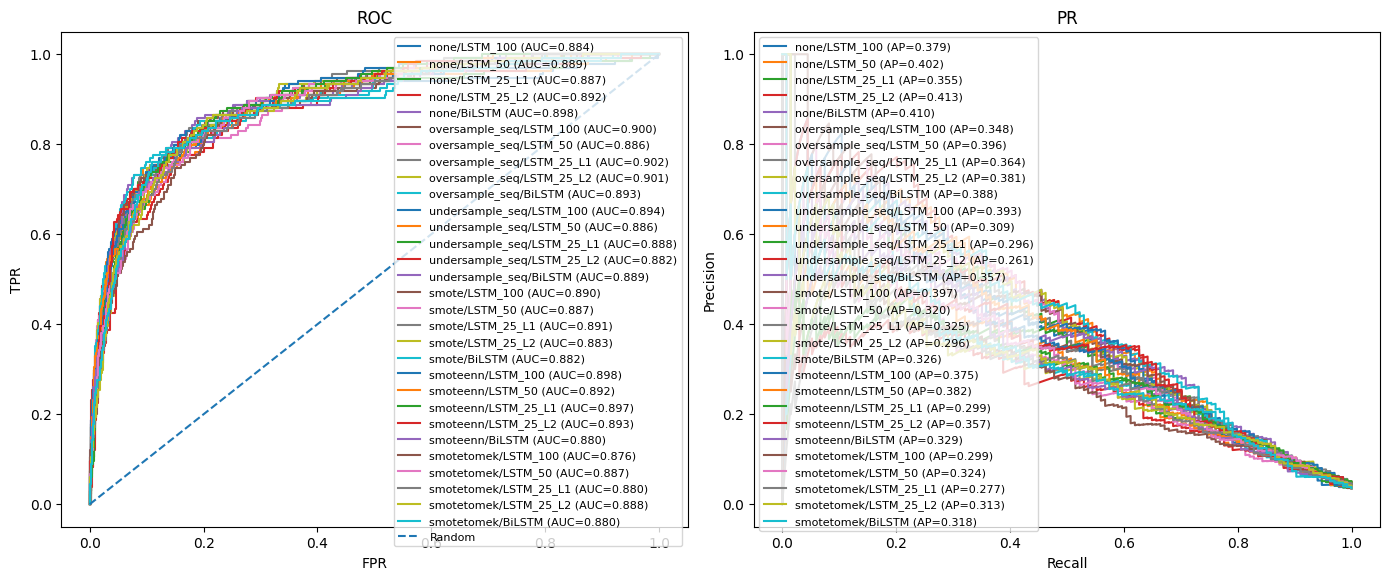


📁 Saved files:
 - plots/combined_roc_pr_curves.png
 - outputs/results_summary_all.csv

Split counts:
Split
train           122
test            122
testBalanced    122
Name: count, dtype: int64

🔽 ORIGINAL TEST — top by Overall/F1_weighted
             Method       Model  Threshold  Overall/F1_weighted  \
13             none     LSTM_50       0.40               0.9632   
34             none  LSTM_25_L2       0.41               0.9627   
31             none  LSTM_25_L2       0.40               0.9622   
49             none      BiLSTM       0.42               0.9622   
37             none  LSTM_25_L2       0.50               0.9616   
46             none      BiLSTM       0.41               0.9613   
52             none      BiLSTM       0.50               0.9609   
43             none      BiLSTM       0.40               0.9608   
7              none    LSTM_100       0.50               0.9604   
127  oversample_seq      BiLSTM       0.60               0.9594   

     Overall/Recall_we

In [11]:
# ==============================================
# Leak-free Ramadan features + Balanced LSTM
# ==============================================

# (Optional) pin versions in Kaggle/Colab:
# !pip install --upgrade pip
# !pip install numpy==1.26.4 scipy==1.13.0 scikit-learn==1.5.1 imbalanced-learn==0.13.0 tensorflow==2.18.0 joblib==1.4.2

import os
import time
import warnings
warnings.filterwarnings("ignore")

import random
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve,
    average_precision_score, auc, mean_squared_error
)

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import joblib

# --------------------
# GLOBAL CONFIG
# --------------------
CSV_INTRADAY_WITH_VISITS = "/kaggle/input/hmcdataset/intraday_with_visits.csv"
CSV_INTRADAY_BASIC       = "/kaggle/input/hmcdataset/intraday.csv"

OUT_HOURLY_CSV = "/kaggle/working/dynamic_hourly_features_ramadan.csv"

RAMADAN_START = pd.to_datetime("2023-03-22")
RAMADAN_END   = pd.to_datetime("2023-04-19")
HYPO_CUTOFF   = 70.0          # mg/dL
MIN_CGM_PER_H = 4
SEQ_LEN       = 24            # hours per sequence window

# Columns you *might* have (safe–checked)
LIFESTYLE_COLS_CANDIDATES = [
    "steps","distance","calories","heart_rate","spo2",
    "deep","light","rem","nap","awake"
]

# Training config
RANDOM_STATE     = 42
THR_MIN, THR_MAX = 0.40, 0.60
AUGMENT_SIGMA    = 0.01  # small Gaussian jitter on train (optional); set None to disable
RESAMPLE_METHODS = [
    "none",           # baseline (class_weight + focal)
    "oversample_seq", # duplicate minority sequences
    "undersample_seq",# downsample majority sequences
    "smote",          # SMOTE on flattened sequences
    "smoteenn",       # SMOTE+ENN on flattened sequences
    "smotetomek"      # SMOTE+Tomek on flattened sequences
]

# --------------------
# General Utilities
# --------------------
def to_dt(x, utc_ok=True):
    return pd.to_datetime(x, errors="coerce", utc=utc_ok)

def ensure_numeric(df, exclude=("patientID","huaweiID","visit_assigned","period_main","start","date","hour","hour_of_day")):
    ex = set(exclude)
    for c in df.columns:
        if c not in ex:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def filter_ramadan(df):
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    return df[(df["date"] >= RAMADAN_START) & (df["date"] <= RAMADAN_END)].copy()

def set_global_seeds(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_global_seeds(RANDOM_STATE)

# ------------------------------------------------------
# Part A — Ramadan hourly features with leak-free PCA
# ------------------------------------------------------
def build_ramadan_hourly_features_leakfree(
    in_csv=CSV_INTRADAY_WITH_VISITS,
    out_csv=OUT_HOURLY_CSV,
    min_cgm_per_hour=MIN_CGM_PER_H,
    test_size=0.2,
    random_state=RANDOM_STATE,
    save_artifacts=True
):
    """
    Build Ramadan hourly features, splitting patients BEFORE any learned transform (scaling/PCA)
    to avoid leakage. Fits scalers/PCA on train patients only, then transforms test patients.

    Returns:
      hourly_out: combined DataFrame with engineered features (train+test concatenated)
      (train_pat, test_pat): tuple of patient ID arrays used for the split
    """
    if not os.path.exists(in_csv):
        raise FileNotFoundError(f"Input not found: {in_csv}")

    df = pd.read_csv(in_csv)

    # --- timestamps / numerics
    df["start"] = to_dt(df.get("start"))
    # Derive date if missing/unreliable
    if "date" not in df.columns or df["date"].isna().all():
        # Safe naive date regardless of tz
        df["date"] = pd.to_datetime(df["start"].dt.date)

    df["hour"] = df["start"].dt.floor("h")
    df["hour_of_day"] = df["hour"].dt.hour
    df = ensure_numeric(df)

    # --- Ramadan filter
    df = filter_ramadan(df)

    # --- require CGM
    if "cgm" not in df.columns:
        raise ValueError("❌ Dataset must include 'cgm' column.")
    df_cgm = df.dropna(subset=["cgm"]).copy()

    # --- only hours with enough CGM samples
    valid_hours = (
        df_cgm.groupby(["patientID","hour"])
              .filter(lambda g: g["cgm"].notna().sum() >= min_cgm_per_hour)
    )

    # --- base hourly CGM stats
    hourly = (
        valid_hours
        .groupby(["patientID","hour"], as_index=False)
        .agg(
            cgm_min=("cgm","min"),
            cgm_max=("cgm","max"),
            cgm_mean=("cgm","mean"),
            cgm_std=("cgm","std")
        )
        .sort_values(["patientID","hour"])
        .reset_index(drop=True)
    )
    hourly["hour_of_day"] = hourly["hour"].dt.hour

    # --- hypo label (any CGM < cutoff during the hour)
    lab = (
        valid_hours.groupby(["patientID","hour"])["cgm"]
        .apply(lambda x: int((x < HYPO_CUTOFF).any()))
        .reset_index(name="hypo_label")
    )
    hourly = hourly.merge(lab, on=["patientID","hour"], how="left")

    # --- composite CGM features
    hourly["cgm_mean_plus_std"]  = hourly["cgm_mean"] + hourly["cgm_std"]
    hourly["cgm_mean_minus_std"] = hourly["cgm_mean"] - hourly["cgm_std"]

    # --- optional lifestyle block
    lifestyle_cols = [c for c in LIFESTYLE_COLS_CANDIDATES if c in df_cgm.columns]
    if lifestyle_cols:
        life_hourly = (
            df_cgm.groupby(["patientID","hour"], as_index=False)[lifestyle_cols]
                  .mean()
                  .fillna(0.0)
        )
        hourly = hourly.merge(life_hourly, on=["patientID","hour"], how="left").fillna(0.0)
    else:
        hourly["pc1_activity_energy"] = 0.0
        hourly["pc2_physiology"]      = 0.0
        hourly["pc3_sleep_rest"]      = 0.0

    # --- split patients BEFORE PCA to avoid leakage
    unique_patients = hourly["patientID"].dropna().unique()
    train_pat, test_pat = train_test_split(unique_patients, test_size=test_size, random_state=random_state)
    train_df = hourly[hourly["patientID"].isin(train_pat)].copy()
    test_df  = hourly[hourly["patientID"].isin(test_pat)].copy()

    # --- fit CGM PCA on train only, transform both
    cgm_cols = ["cgm_min","cgm_max","cgm_mean","cgm_std"]
    scal_cgm = StandardScaler().fit(train_df[cgm_cols].fillna(0.0))
    pca_cgm  = PCA(n_components=3, random_state=random_state).fit(scal_cgm.transform(train_df[cgm_cols].fillna(0.0)))

    def _apply_cgm(df_in):
        X = scal_cgm.transform(df_in[cgm_cols].fillna(0.0))
        Z = pca_cgm.transform(X)
        out = df_in.copy()
        out["pca_cgm1"], out["pca_cgm2"], out["pca_cgm3"] = Z[:,0], Z[:,1], Z[:,2]
        return out

    train_df = _apply_cgm(train_df)
    test_df  = _apply_cgm(test_df)

    # --- lifestyle PCA (if present), also fit on train only
    if lifestyle_cols:
        scal_life = StandardScaler().fit(train_df[lifestyle_cols])
        pca_life  = PCA(n_components=3, random_state=random_state).fit(scal_life.transform(train_df[lifestyle_cols]))

        def _apply_life(df_in):
            X = scal_life.transform(df_in[lifestyle_cols])
            Z = pca_life.transform(X)
            out = df_in.copy()
            out["pc1_activity_energy"] = Z[:,0]
            out["pc2_physiology"]      = Z[:,1]
            out["pc3_sleep_rest"]      = Z[:,2]
            return out

        train_df = _apply_life(train_df)
        test_df  = _apply_life(test_df)

    # --- save & return (combined for convenience)
    hourly_out = pd.concat([train_df, test_df], axis=0).sort_values(["patientID","hour"]).reset_index(drop=True)
    hourly_out.to_csv(out_csv, index=False)
    print(f"✅ Saved leak‑free Ramadan hourly features to: {out_csv}")

    # Optionally save artifacts for reproducibility
    if save_artifacts:
        os.makedirs("/kaggle/working/artifacts", exist_ok=True)
        joblib.dump({"scal_cgm":scal_cgm, "pca_cgm":pca_cgm, "cols":cgm_cols},
                    "/kaggle/working/artifacts/cgm_pca.joblib")
        if lifestyle_cols:
            joblib.dump({"scal_life":scal_life, "pca_life":pca_life, "cols":lifestyle_cols},
                        "/kaggle/working/artifacts/life_pca.joblib")

    return hourly_out, (train_pat, test_pat)

# ------------------------------------------------------
# Part B — LSTM sequences from HOURLY CSV (supports PCs)
# ------------------------------------------------------
def build_lstm_sequences_from_hourly(
    hourly_df_or_path=OUT_HOURLY_CSV,
    seq_len=SEQ_LEN,
    feature_cols=("cgm_mean","cgm_std","pc1_activity_energy"),
    split_patients=None  # <-- (train_pat, test_pat)
):
    """
    Build sequences directly from the Ramadan hourly features CSV/DataFrame.
    Use this when you want columns like 'pc1_activity_energy', 'pca_cgm1', etc.
    Pass split_patients from the leak-free PCA step to avoid leakage.
    """
    if isinstance(hourly_df_or_path, (str, Path)):
        if not os.path.exists(hourly_df_or_path):
            raise FileNotFoundError(f"Hourly features not found: {hourly_df_or_path}")
        hourly = pd.read_csv(hourly_df_or_path)
    else:
        hourly = hourly_df_or_path.copy()

    req = {"patientID","hour","hypo_label"}
    missing = req - set(hourly.columns)
    if missing:
        raise KeyError(f"Hourly features missing required columns: {missing}")

    hourly["hour"] = pd.to_datetime(hourly["hour"], errors="coerce")
    feature_cols = list(feature_cols)
    miss = [c for c in feature_cols if c not in hourly.columns]
    if miss:
        raise KeyError(f"Requested feature(s) not found in hourly CSV: {miss}")

    hourly = hourly.sort_values(["patientID","hour"]).reset_index(drop=True)

    if split_patients is None:
        raise ValueError("Pass split_patients=(train_pat, test_pat) from the leak‑free PCA step.")
    train_pat, test_pat = split_patients
    train_df = hourly[hourly["patientID"].isin(train_pat)].copy()
    test_df  = hourly[hourly["patientID"].isin(test_pat)].copy()

    def build_sequences(df_in, feature_cols, label_col="hypo_label", seq_len=SEQ_LEN):
        X, y = [], []
        for pid, grp in df_in.groupby("patientID"):
            grp = grp.sort_values("hour").reset_index(drop=True)
            for i in range(len(grp) - seq_len):
                X.append(grp.loc[i:i+seq_len-1, feature_cols].values)
                y.append(int(grp.loc[i+seq_len, label_col]))
        return np.array(X), np.array(y)

    X_train, y_train = build_sequences(train_df, feature_cols, seq_len=seq_len)
    X_test,  y_test  = build_sequences(test_df,  feature_cols, seq_len=seq_len)

    print(f"✅ Sequences (Hourly/PCs, leak‑free) — train: {X_train.shape}, test: {X_test.shape} | features={feature_cols}")
    return (X_train, y_train, X_test, y_test), (train_df, test_df)

# ------------------------------------------------------
# Balanced LSTM pipeline utilities (metrics, resampling)
# ------------------------------------------------------
def _best_threshold_in_range(thresholds, scores, thr_min=THR_MIN, thr_max=THR_MAX):
    thresholds = np.asarray(thresholds, dtype=float)
    scores     = np.asarray(scores, dtype=float)
    mask = np.isfinite(thresholds) & (thresholds >= thr_min) & (thresholds <= thr_max)
    if mask.any():
        idx_in = int(np.nanargmax(scores[mask]))
        idx    = np.where(mask)[0][idx_in]
        return float(thresholds[idx]), True
    idx = int(np.nanargmax(scores))
    return float(np.clip(thresholds[idx], thr_min, thr_max)), False

def focal_loss(gamma=2.0, alpha=0.25):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
    eps = tf.keras.backend.epsilon()
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        ce = bce(y_true, y_pred)
        p_t = y_true * y_pred + (1.0 - y_true) * (1.0 - y_pred)
        alpha_t = y_true * alpha + (1.0 - y_true) * (1.0 - alpha)
        modulating = tf.pow(1.0 - p_t, gamma)
        return alpha_t * modulating * ce
    return loss

def _safe_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    if cm.shape != (2,2):
        full = np.zeros((2,2), dtype=int)
        full[:cm.shape[0], :cm.shape[1]] = cm
        cm = full
    return cm

def _specificity_overall(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return tn / (tn + fp + 1e-8)

def _specificity_per_class(y_true, y_pred, positive_label):
    # TNR for the "not positive_label" class, computed by binarizing on that label
    y_true_bin = (np.asarray(y_true).ravel() == positive_label).astype(int)
    y_pred_bin = (np.asarray(y_pred).ravel() == positive_label).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1]).ravel()
    return tn / (tn + fp + 1e-8)

def evaluate_full_metrics(y_true, y_pred, y_prob=None):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_pred = np.asarray(y_pred).astype(int).ravel()
    cm = _safe_confusion_matrix(y_true, y_pred)

    metrics = {}
    for lbl in [0,1]:
        metrics[f"Class{lbl}/Precision"]   = precision_score(y_true, y_pred, pos_label=lbl, zero_division=0)
        metrics[f"Class{lbl}/Recall"]      = recall_score(y_true, y_pred,    pos_label=lbl, zero_division=0)
        metrics[f"Class{lbl}/F1"]          = f1_score(y_true, y_pred,        pos_label=lbl, zero_division=0)
        metrics[f"Class{lbl}/Specificity"] = _specificity_per_class(y_true, y_pred, positive_label=lbl)
        metrics[f"Class{lbl}/Support"]     = int(np.sum(y_true == lbl))

    # overall (hard preds)
    metrics["Overall/Accuracy"]             = accuracy_score(y_true, y_pred)
    metrics["Overall/Precision_macro"]      = precision_score(y_true, y_pred, average='macro',    zero_division=0)
    metrics["Overall/Precision_weighted"]   = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics["Overall/Recall_macro"]         = recall_score(y_true, y_pred,    average='macro',    zero_division=0)
    metrics["Overall/Recall_weighted"]      = recall_score(y_true, y_pred,    average='weighted', zero_division=0)
    metrics["Overall/F1_macro"]             = f1_score(y_true, y_pred,        average='macro',    zero_division=0)
    metrics["Overall/F1_weighted"]          = f1_score(y_true, y_pred,        average='weighted', zero_division=0)
    metrics["Overall/Specificity"]          = _specificity_overall(y_true, y_pred)
    mse_pred                                = mean_squared_error(y_true, y_pred)
    metrics["Overall/MSE_pred"]             = mse_pred
    metrics["Overall/RMSE_pred"]            = float(np.sqrt(mse_pred))

    # prob-based
    if y_prob is not None:
        y_prob = np.asarray(y_prob, dtype=float).ravel()
        try:  metrics["Overall/ROC-AUC"] = roc_auc_score(y_true, y_prob)
        except ValueError: metrics["Overall/ROC-AUC"] = np.nan
        try:  metrics["Overall/PR-AUC"]  = average_precision_score(y_true, y_prob)
        except ValueError: metrics["Overall/PR-AUC"] = np.nan
        mse_prob                          = mean_squared_error(y_true, y_prob)
        metrics["Overall/MSE_prob"]       = mse_prob
        metrics["Overall/RMSE_prob"]      = float(np.sqrt(mse_prob))
    else:
        metrics["Overall/ROC-AUC"]  = np.nan
        metrics["Overall/PR-AUC"]   = np.nan
        metrics["Overall/MSE_prob"] = np.nan
        metrics["Overall/RMSE_prob"]= np.nan

    return metrics

def make_class_weight(y):
    y  = np.asarray(y).astype(int).ravel()
    n0 = max(1, (y==0).sum()); n1 = max(1, (y==1).sum()); N = n0+n1
    w0 = N/(2.0*n0); w1 = N/(2.0*n1)
    return {0: float(w0), 1: float(w1)}

def augment(X, y, sigma=AUGMENT_SIGMA):
    if sigma is None or sigma <= 0: 
        return X, y
    noise = np.random.normal(0, sigma, X.shape)
    return np.vstack([X, X+noise]), np.hstack([y, y])

def seq_resample(X, y, method="none", random_state=RANDOM_STATE):
    """
    Sequence-level resampling.
    method ∈ {
      "none",
      "oversample_seq", "undersample_seq",        # window-level (no interpolation)
      "smote", "smoteenn", "smotetomek"           # flattened window resampling
    }
    """
    X = np.asarray(X); y = np.asarray(y).astype(int).ravel()
    n, T, F = X.shape

    if method == "none":
        return X, y

    if method in {"oversample_seq","undersample_seq"}:
        rng = np.random.default_rng(random_state)
        idx0 = np.where(y==0)[0]; idx1 = np.where(y==1)[0]
        n0, n1 = len(idx0), len(idx1)
        if n0==0 or n1==0:
            return X, y

        if method == "oversample_seq":
            if n1 < n0:
                add = rng.choice(idx1, size=n0-n1, replace=True)
                keep = np.concatenate([idx0, idx1, add])
            else:
                add = rng.choice(idx0, size=n1-n0, replace=True)
                keep = np.concatenate([idx0, idx1, add])
        else:
            if n0 > n1:
                keep0 = rng.choice(idx0, size=n1, replace=False)
                keep  = np.concatenate([keep0, idx1])
            else:
                keep1 = rng.choice(idx1, size=n0, replace=False)
                keep  = np.concatenate([idx0, keep1])

        rng.shuffle(keep)
        return X[keep], y[keep]

    # SMOTE family on flattened sequences with guard
    Xf = X.reshape(n, -1)
    minority_n = int((y==1).sum())
    majority_n = int((y==0).sum())
    if minority_n < 2 or majority_n < 2:
        print("⚠️ Not enough samples for SMOTE/SMOTEENN/SMOTETomek; skipping resampling.")
        return X, y

    if method == "smote":
        k_neighbors = max(1, min(5, minority_n-1))
        sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
        Xr, yr = sm.fit_resample(Xf, y)
    elif method == "smoteenn":
        Xr, yr = SMOTEENN(random_state=random_state).fit_resample(Xf, y)
    elif method == "smotetomek":
        Xr, yr = SMOTETomek(random_state=random_state).fit_resample(Xf, y)
    else:
        raise ValueError(f"Unknown resampling method: {method}")
    return Xr.reshape(-1, T, F), yr

def make_balanced_test(X_test, y_test, random_state=RANDOM_STATE):
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test).astype(int).ravel()
    idx0, idx1 = np.where(y_test==0)[0], np.where(y_test==1)[0]
    if len(idx0)==0 or len(idx1)==0: return X_test, y_test
    m = min(len(idx0), len(idx1))
    rs = np.random.RandomState(random_state)
    keep = np.concatenate([rs.choice(idx0, m, replace=False), rs.choice(idx1, m, replace=False)])
    rs.shuffle(keep)
    return X_test[keep], y_test[keep]

def define_models(input_shape):
    return {
        "LSTM_100": Sequential([
            Input(shape=input_shape),
            LSTM(100, return_sequences=True), Dropout(0.2),
            LSTM(50), Dropout(0.2),
            Dense(25, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_50": Sequential([
            Input(shape=input_shape),
            LSTM(50, return_sequences=True), Dropout(0.2),
            LSTM(25), Dropout(0.2),
            Dense(10, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_25_L1": Sequential([
            Input(shape=input_shape),
            LSTM(50, return_sequences=True, kernel_regularizer=l1(1e-5)), Dropout(0.2),
            LSTM(25, kernel_regularizer=l1(1e-5)), Dropout(0.2),
            Dense(10, activation='relu', kernel_regularizer=l1(1e-5)),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_25_L2": Sequential([
            Input(shape=input_shape),
            LSTM(50, return_sequences=True, kernel_regularizer=l2(1e-5)), Dropout(0.2),
            LSTM(25, kernel_regularizer=l2(1e-5)), Dropout(0.2),
            Dense(10, activation='relu', kernel_regularizer=l2(1e-5)),
            Dense(1, activation='sigmoid')
        ]),
        "BiLSTM": Sequential([
            Input(shape=input_shape),
            Bidirectional(LSTM(64, return_sequences=True)), Dropout(0.2),
            Bidirectional(LSTM(32)), Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
    }

def run_balanced_lstm_pipeline(X_train, y_train, X_test, y_test,
                               resample_methods=RESAMPLE_METHODS,
                               thr_min=THR_MIN, thr_max=THR_MAX,
                               random_state=RANDOM_STATE):
    """
    Trains all models across resampling methods, writes plots + CSV summary,
    and returns the results DataFrame.
    """
    os.makedirs("checkpoints", exist_ok=True)
    os.makedirs("plots", exist_ok=True)
    os.makedirs("outputs", exist_ok=True)

    # tiny augmentation (optional)
    X_train_aug, y_train_aug = augment(X_train, y_train, sigma=AUGMENT_SIGMA)

    # balanced test copy (for fair diagnostic read)
    X_test_bal, y_test_bal = make_balanced_test(X_test, y_test)

    results = {}       # key -> metrics dict
    roc_data = {}      # (method, model) -> (fpr, tpr, auc)
    pr_data  = {}      # (method, model) -> (recall, precision, ap)
    best_thresholds = {}  # (method, model) -> {"youden": t, "f1": t}

    def train_eval_one(method_name, model_name, model, Xtr, ytr, Xte, yte, XteB, yteB):
        tag = f"{method_name}__{model_name}"
        print(f"\n🚀 Training [{tag}] with class-weighted focal loss")
        es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
        cp = ModelCheckpoint(f"checkpoints/{tag}.h5", save_best_only=True, monitor='val_loss', verbose=0)
        model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

        class_weight = make_class_weight(ytr)
        t0 = time.time()
        model.fit(Xtr, ytr, epochs=5, batch_size=32,
                  validation_data=(Xte, yte),
                  callbacks=[es, cp], verbose=1,
                  class_weight=class_weight)
        print(f"⏱️ Training Time: {time.time()-t0:.2f}s")

        # probabilities
        p_tr  = model.predict(Xtr,  verbose=0).ravel()
        p_te  = model.predict(Xte,  verbose=0).ravel()
        p_teB = model.predict(XteB, verbose=0).ravel()

        # thresholds (on ORIGINAL test), constrained to [thr_min, thr_max]
        try:
            fpr, tpr, thr_roc = roc_curve(yte, p_te); auc_roc = auc(fpr, tpr)
        except ValueError:
            fpr, tpr, thr_roc, auc_roc = np.array([0,1]), np.array([0,1]), np.array([0.5]), np.nan
        youden = tpr - fpr
        t_roc, _ = _best_threshold_in_range(thr_roc, youden, thr_min, thr_max)

        prec, rec, thr_pr = precision_recall_curve(yte, p_te)
        f1s = 2*prec[:-1]*rec[:-1] / (prec[:-1]+rec[:-1]+1e-8)
        t_pr, _ = _best_threshold_in_range(thr_pr, f1s, thr_min, thr_max)
        ap_val  = average_precision_score(yte, p_te)

        roc_data[(method_name, model_name)] = (fpr, tpr, auc_roc)
        pr_data[(method_name, model_name)]  = (rec, prec, ap_val)
        best_thresholds[(method_name, model_name)] = {"youden": t_roc, "f1": t_pr}
        print(f"📌 [{tag}] thresholds → Youden={t_roc:.4f}, PR-F1={t_pr:.4f} (window [{thr_min},{thr_max}])")

        eval_ts = sorted(set([thr_min, 0.50, thr_max, float(t_roc), float(t_pr)]))
        # evaluate at all thresholds on train / test / testBalanced
        for t in eval_ts:
            yhat_tr  = (p_tr  >= t).astype(int)
            yhat_te  = (p_te  >= t).astype(int)
            yhat_teB = (p_teB >= t).astype(int)

            results[f"{tag}__thr_{t:.2f}__train"]         = evaluate_full_metrics(ytr,  yhat_tr,  p_tr)
            results[f"{tag}__thr_{t:.2f}__test"]          = evaluate_full_metrics(yte,  yhat_te,  p_te)
            results[f"{tag}__thr_{t:.2f}__testBalanced"]  = evaluate_full_metrics(yteB, yhat_teB, p_teB)

    # run all methods x models
    input_shape = (X_train_aug.shape[1], X_train_aug.shape[2])
    for METHOD in resample_methods:
        Xtr_rs, ytr_rs = seq_resample(X_train_aug, y_train_aug, method=METHOD, random_state=random_state)
        print(f"\n🔁 Resampling: {METHOD} → X={Xtr_rs.shape}, y={Counter(ytr_rs)}")
        for mname, model in define_models(input_shape).items():
            train_eval_one(METHOD, mname, model, Xtr_rs, ytr_rs, X_test, y_test, X_test_bal, y_test_bal)

    # --------------------------
    # Curves (optional plots)
    # --------------------------
    plt.figure(figsize=(14,6))
    # ROC
    plt.subplot(1,2,1)
    for (meth, mname), (fpr, tpr, auc_roc) in roc_data.items():
        plt.plot(fpr, tpr, label=f'{meth}/{mname} (AUC={auc_roc:.3f})')
    plt.plot([0,1],[0,1],'--',label='Random')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC'); plt.legend(fontsize=8)
    # PR
    plt.subplot(1,2,2)
    for (meth, mname), (rec, prec, ap) in pr_data.items():
        plt.plot(rec, prec, label=f'{meth}/{mname} (AP={ap:.3f})')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR'); plt.legend(fontsize=8)
    plt.tight_layout(); plt.savefig("plots/combined_roc_pr_curves.png", dpi=300); plt.show()

    # --------------------------
    # Summaries
    # --------------------------
    results_df = pd.DataFrame(results).T
    results_df = results_df.reset_index().rename(columns={"index":"Key"})

    # Split extraction
    k = results_df["Key"].str.strip()
    split = np.where(k.str.endswith("__train"), "train",
             np.where(k.str.endswith("__testBalanced"), "testBalanced",
             np.where(k.str.endswith("__test"), "test", np.nan)))
    results_df["Split"] = split

    # Method, Model, Threshold extraction
    parts = k.str.split("__")
    results_df["Method"] = parts.str[0]
    results_df["Model"]  = parts.str[1]
    thr_str = parts.str[2].str.replace("thr_","", regex=False)
    with np.errstate(all='ignore'):
        results_df["Threshold"] = pd.to_numeric(thr_str, errors="coerce")

    # Save
    results_df.round(6).to_csv("outputs/results_summary_all.csv", index=False)
    print("\n📁 Saved files:")
    print(" - plots/combined_roc_pr_curves.png")
    print(" - outputs/results_summary_all.csv")

    # Quick sanity
    print("\nSplit counts:")
    print(results_df["Split"].value_counts(dropna=False))

    # Leaderboards
    eval_test_df  = results_df[results_df["Split"]=="test"].copy()
    eval_tbal_df  = results_df[results_df["Split"]=="testBalanced"].copy()

    def top_k(df, by_col, k=10, cols=None):
        if df.empty:
            return pd.DataFrame(columns=(cols or []))
        if cols is None:
            cols = ['Method','Model','Threshold','Overall/F1_weighted','Overall/Recall_weighted',
                    'Overall/Precision_weighted','Overall/ROC-AUC','Overall/PR-AUC','Overall/Accuracy']
        present = [c for c in cols if c in df.columns]
        return df.sort_values(by_col, ascending=False)[present].head(k).round(4)

    print("\n🔽 ORIGINAL TEST — top by Overall/F1_weighted")
    print(top_k(eval_test_df, 'Overall/F1_weighted'))

    print("\n🔽 BALANCED TEST — top by Overall/F1_weighted")
    print(top_k(eval_tbal_df, 'Overall/F1_weighted'))

    def best_per_model(df):
        if df.empty:
            return df
        idx = df.groupby(['Method','Model'])['Overall/F1_weighted'].idxmax()
        return df.loc[idx].sort_values(['Overall/F1_weighted'], ascending=False)

    overall_cols = [
        'Overall/Accuracy','Overall/Precision_macro','Overall/Recall_macro','Overall/F1_macro',
        'Overall/Precision_weighted','Overall/Recall_weighted','Overall/F1_weighted',
        'Overall/Specificity','Overall/ROC-AUC','Overall/PR-AUC',
        'Overall/MSE_pred','Overall/RMSE_pred','Overall/MSE_prob','Overall/RMSE_prob'
    ]
    class_cols = [
        'Class0/Precision','Class0/Recall','Class0/F1','Class0/Specificity','Class0/Support',
        'Class1/Precision','Class1/Recall','Class1/F1','Class1/Specificity','Class1/Support'
    ]

    print("\n=== ORIGINAL TEST — best per (Method,Model) ===")
    best_test = best_per_model(eval_test_df)
    if best_test.empty:
        print("⚠️ No TEST rows found — check Split counts above.")
    else:
        print(best_test[['Method','Model','Threshold']+[c for c in overall_cols if c in best_test.columns]].round(4))
        print("\n--- Per-class breakdown:")
        print(best_test[['Method','Model','Threshold']+[c for c in class_cols if c in best_test.columns]].round(4))

    print("\n=== BALANCED TEST — best per (Method,Model) ===")
    best_tbal = best_per_model(eval_tbal_df)
    if best_tbal.empty:
        print("⚠️ No BALANCED TEST rows found — check Split counts above.")
    else:
        print(best_tbal[['Method','Model','Threshold']+[c for c in overall_cols if c in best_tbal.columns]].round(4))
        print("\n--- Per-class breakdown:")
        print(best_tbal[['Method','Model','Threshold']+[c for c in class_cols if c in best_tbal.columns]].round(4))

    return results_df

# ------------------------------------------------------
# CGM-only (raw intraday) sequence builder
# ------------------------------------------------------
def build_cgm_only_sequences_from_intraday(
    in_csv=CSV_INTRADAY_BASIC,
    seq_len=SEQ_LEN,
    label_cutoff=HYPO_CUTOFF,
    min_cgm_per_hour=MIN_CGM_PER_H,
    feature_cols=("cgm_mean",),  # customize: ("cgm_mean","cgm_std","cgm_min","cgm_max")
    test_size=0.2,
    random_state=RANDOM_STATE
):
    """
    Build CGM-only hourly features from intraday and convert to sequences.
    Splits by patient to avoid leakage.
    """
    if not os.path.exists(in_csv):
        raise FileNotFoundError(f"Input not found: {in_csv}")

    df = pd.read_csv(in_csv)
    df["start"] = to_dt(df.get("start"))
    df["hour"]  = df["start"].dt.floor("h")

    base = df[["patientID","hour","cgm"]].dropna(subset=["cgm"])
    valid = base.groupby(["patientID","hour"]).filter(lambda g: g["cgm"].notna().sum() >= min_cgm_per_hour)

    feats = (
        valid.groupby(["patientID","hour"])
             .agg(
                 cgm_std=("cgm","std"),
                 cgm_min=("cgm","min"),
                 cgm_mean=("cgm","mean"),
                 cgm_max=("cgm","max"),
                 hypo_label=("cgm", lambda x: int((x < label_cutoff).any()))
             )
             .reset_index()
             .sort_values(["patientID","hour"])
             .reset_index(drop=True)
    )

    # leakage-proof split
    unique_patients = feats["patientID"].unique()
    train_pat, test_pat = train_test_split(unique_patients, test_size=test_size, random_state=random_state)
    train_df = feats[feats["patientID"].isin(train_pat)].copy()
    test_df  = feats[feats["patientID"].isin(test_pat)].copy()

    feature_cols = list(feature_cols)
    for col in feature_cols + ["hypo_label"]:
        if col not in feats.columns:
            raise KeyError(f"Column '{col}' not found. Available: {feats.columns.tolist()}")

    def build_sequences(df_in, feature_cols, label_col="hypo_label", seq_len=seq_len):
        X, y = [], []
        for pid, grp in df_in.groupby("patientID"):
            grp = grp.sort_values("hour").reset_index(drop=True)
            for i in range(len(grp) - seq_len):
                X.append(grp.loc[i:i+seq_len-1, feature_cols].values)
                y.append(int(grp.loc[i+seq_len, label_col]))
        return np.array(X), np.array(y)

    X_train, y_train = build_sequences(train_df, feature_cols)
    X_test,  y_test  = build_sequences(test_df,  feature_cols)

    print(f"✅ Sequences (CGM-only) — train: {X_train.shape}, test: {X_test.shape} | features={feature_cols}")
    return (X_train, y_train, X_test, y_test), (train_df, test_df)

# ------------------------------------------------------
# Main control flags
# ------------------------------------------------------
RUN_FEATURE_BUILD          = False  # Build Ramadan hourly features + leak-free PCA
RUN_TRAINING_FROM_HOURLY   = True  # Train models using sequences built from hourly features
RUN_TRAINING_FROM_CGM_ONLY = False  # Train models using CGM-only sequences from raw intraday

# ------------------------------------------------------
# Orchestrate
# ------------------------------------------------------
if __name__ == "__main__":
    hourly_features = None
    split_pat       = None

    # Part A: Ramadan hourly features with leak-free PCA
    if RUN_FEATURE_BUILD or RUN_TRAINING_FROM_HOURLY:
        try:
            hourly_features, split_pat = build_ramadan_hourly_features_leakfree(
                in_csv=CSV_INTRADAY_WITH_VISITS,
                out_csv=OUT_HOURLY_CSV,
                min_cgm_per_hour=MIN_CGM_PER_H,
                test_size=0.2,
                random_state=RANDOM_STATE
            )
        except Exception as e:
            print(f"[WARN] Skipping Ramadan feature build: {e}")

    # Part B option 1 — Train from HOURLY (PC) sequences
    if RUN_TRAINING_FROM_HOURLY:
        try:
            if split_pat is None:
                raise RuntimeError("No patient split found. Ensure feature build step ran successfully.")
            (X_train, y_train, X_test, y_test), _ = build_lstm_sequences_from_hourly(
                hourly_df_or_path=OUT_HOURLY_CSV,
                seq_len=SEQ_LEN,
                feature_cols=("cgm_mean","cgm_std","pc1_activity_energy"),
                split_patients=split_pat
            )
            _ = run_balanced_lstm_pipeline(X_train, y_train, X_test, y_test)
        except Exception as e:
            print(f"[WARN] Skipping hourly-based training: {e}")

    # Part B option 2 — Train from CGM-only (raw intraday) sequences
    if RUN_TRAINING_FROM_CGM_ONLY:
        try:
            (X_train_cgm, y_train_cgm, X_test_cgm, y_test_cgm), _ = build_cgm_only_sequences_from_intraday(
                in_csv=CSV_INTRADAY_BASIC,
                seq_len=SEQ_LEN,
                label_cutoff=HYPO_CUTOFF,
                min_cgm_per_hour=MIN_CGM_PER_H,
                feature_cols=("cgm_mean",)  # or: ("cgm_mean","cgm_std","cgm_min","cgm_max")
            )
            _ = run_balanced_lstm_pipeline(X_train_cgm, y_train_cgm, X_test_cgm, y_test_cgm)
        except Exception as e:
            print(f"[WARN] Skipping CGM-only training: {e}")
